# Computation of aeolian Fe depostion: time-average versus online fields

Iron flux is computed online in the model using `dust` and `black_carbon` fields simulated in the atmosphere.

In [1]:
%matplotlib inline
import os
from glob import glob

from itertools import product

import numpy as np
import cftime
import xarray as xr

import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import util

## Parameters

In [2]:
kgm2s_to_gcm2s = 0.1
molw_Fe = 55.845

class iron_flux_parms(object):
    def __init__(self, **kwargs):
        self.dust_ratio_thres = 60.0

        self.fe_bioavail_frac_offset = 0.01
        self.dust_ratio_to_fe_bioavail_frac = 1.0 / 170.0

        self.atm_bc_fe_bioavail_frac = 0.06
        self.atm_fe_to_bc_ratio = 1.0
        self.iron_frac_in_atm_coarse_dust = 0.035   
        self.iron_frac_in_atm_fine_dust = 0.035
        self.iron_frac_in_seaice_bc = 0.06
        self.iron_frac_in_seaice_dust = 0.035
        
        for key, val in kwargs.items():
            if key not in self.__dict__:
                raise ValueError(f'unknown parameter: {key}')
            self.__dict__[key] = val

## Fe flux parameterization

In [3]:
def atm_fe_dust_bioavail_frac(atm_coarse_dust_flux, atm_fine_dust_flux, parms):       
    """Compute the bioavailable iron fraction"""    
    
    coarse_to_fine_ratio = atm_coarse_dust_flux / atm_fine_dust_flux
    
    return xr.where(atm_coarse_dust_flux < parms.dust_ratio_thres * atm_fine_dust_flux,
                    parms.fe_bioavail_frac_offset + parms.dust_ratio_to_fe_bioavail_frac * \
                    (parms.dust_ratio_thres - coarse_to_fine_ratio),
                    parms.fe_bioavail_frac_offset)


def atm_fe_dep(atm_coarse_dust_flux, atm_fine_dust_flux, atm_black_carbon_flux, parms):
    """Compute Fe deposition (mol/m^2/yr)"""

    return atm_fe_dust_bioavail_frac(atm_coarse_dust_flux, atm_fine_dust_flux, parms) * \
           ((parms.iron_frac_in_atm_fine_dust * atm_fine_dust_flux[:] + \
             parms.iron_frac_in_atm_coarse_dust * atm_coarse_dust_flux[:]) + \
            parms.atm_bc_fe_bioavail_frac  * parms.atm_fe_to_bc_ratio * atm_black_carbon_flux[:]) * \
           1e4 * 365. * 86400. / molw_Fe


def compute_iron_flux(ds, parms=None, coarse_to_fine_ratio=None):
    '''Compute `iron_flux` from dust and black carbon fields'''
    
    if parms is None:
        parms = iron_flux_parms()
        

    
    atm_coarse_dust_flux = (ds.DSTX02WD + ds.DSTX03WD + ds.DSTX04WD + 
                            ds.DSTX02DD + ds.DSTX03DD + ds.DSTX04DD) * kgm2s_to_gcm2s

    atm_fine_dust_flux = (ds.DSTX01DD + ds.DSTX01WD) * kgm2s_to_gcm2s
    
    atm_black_carbon_flux = (ds.BCPHIDRY + ds.BCPHODRY + ds.BCDEPWET) * kgm2s_to_gcm2s
    
    iron_flux = atm_fe_dep(atm_coarse_dust_flux, atm_fine_dust_flux, atm_black_carbon_flux, parms)
    iron_flux.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
    
    return iron_flux

## Get CAM coordinates and land-mask

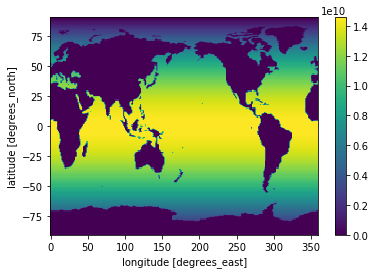

In [4]:
inputdata = '/glade/p/cesmdata/cseg/inputdata'

with xr.open_dataset(f'{inputdata}/atm/cam/ocnfrac/domain.camocn.0.9x1.25_gx1v7_170215.nc') as ds:
    OCNFRAC = ds.frac.rename({'nj': 'lat', 'ni': 'lon'})

with xr.open_dataset(f'{inputdata}/atm/cam/coords/fv_0.9x1.25.nc') as ds:
    AREA = xr.DataArray(util.compute_grid_area(ds).values, dims=('lat', 'lon'))
    lon = ds.lon
    lat = ds.lat

AREA['lon'] = lon
AREA['lat'] = lat
OCNFRAC['lon'] = lon
OCNFRAC['lat'] = lat
    
AREA = AREA * OCNFRAC

AREA.plot()

## Read the dataset we're using in ocean-ice runs

In [5]:
presaero_path = '/glade/p/cesmdata/cseg/inputdata/atm/cam/chem/trop_mozart_aero/aero'
presaero_file = 'aerosoldep_WACCM.ensmean_monthly_hist_1849-2015_0.9x1.25_CMIP6_c180926.nc'
ds5 = xr.open_dataset(f'{presaero_path}/{presaero_file}')


ds5['time_bnd_diff'] = xr.DataArray(np.diff(cftime.date2num(ds5.time_bnds, 
                                                            units='days since 0001-01-01', 
                                                            calendar='noleap'), axis=1)[:, 0]/365., 
                                    dims=('time'), 
                                    coords={'time': ds5.time})

ds5.time_bnd_diff['units'] = 'year'

# overwrite coords to deal with round-off level diffs
ds5['lon'] = lon
ds5['lat'] = lat
ds5 = ds5.reindex({'lat': lat, 'lon': lon})

ds5                        

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, ntb: 2, time: 2004)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time           (time) object 1849-01-16 12:00:00 ... 2015-12-16 12:00:00
Dimensions without coordinates: ntb
Data variables:
    BCDEPWET       (time, lat, lon) float32 1.2756474e-16 ... 3.2354402e-14
    BCPHIDRY       (time, lat, lon) float32 1.2539693e-17 ... 5.1245095e-15
    BCPHODRY       (time, lat, lon) float32 5.0905227e-19 ... 2.3128079e-14
    DSTX01DD       (time, lat, lon) float32 3.5160407e-17 ... 1.4782036e-15
    DSTX01WD       (time, lat, lon) float32 4.7634047e-16 ... 3.4891635e-14
    DSTX02DD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX02WD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX03DD       (time, lat, lon) float32 1.9575008e-16 ... 2.3046262e-13
    D

## Read original daily BWHIST data for year 2000

Could also look at BHIST ensemble member 10, in the directory: 
/glade/p/cgd/tss/people/oleson/b.e21.BHIST.f09_g17.CMIP6-historical.010/cpl/hist.mon

In [6]:
# read the ensemble members
dsd_list = []
for i in range(1, 4):
    case = f'b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.{i:03d}'
    droot = f'/glade/p/cgd/tss/people/oleson/{case}/cpl/hist.mon'
    files = sorted(glob(f'{droot}/{case}.cpl.ha2x1d.2000-??.nc'))

    dsd_list.append(xr.open_mfdataset(files, combine='by_coords'))

# concat along ensemble dim
dsd = xr.concat(dsd_list, dim='ens', data_vars=[v for v, da in dsd_list[0].data_vars.items()
                                                if 'a2x1d_ny' in da.dims])

# add/rename variables
dsd = util.cpl_names_to_datm_names(dsd)
dsd = dsd.rename({'a2x1d_ny': 'lat', 'a2x1d_nx': 'lon', 'doma_nx': 'lon', 'doma_ny': 'lat'})
dsd = dsd.drop([v for v in dsd.data_vars if 'doma_' in v or 'a2x1d' in v])

# write coords to deal with round-off level diffs
dsd['lon'] = lon
dsd['lat'] = lat
dsd = dsd.reindex({'lat': lat, 'lon': lon})

dsd['time_bnd_diff'] = xr.DataArray(np.diff(cftime.date2num(dsd.time_bnds, 
                                                            units='days since 0001-01-01', 
                                                            calendar='noleap'), axis=1)[:, 0]/365., 
                                    dims=('time'), 
                                    coords={'time': dsd.time})

dsd.time_bnd_diff['units'] = 'year'

dsd

<xarray.Dataset>
Dimensions:        (ens: 3, lat: 192, lon: 288, ntb: 2, time: 365)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time           (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
Dimensions without coordinates: ens, ntb
Data variables:
    time_bnds      (time, ntb) object 2000-01-01 00:00:00 ... 2001-01-01 00:00:00
    BCDEPWET       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    BCPHODRY       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    BCPHIDRY       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    OCDEPWET       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarray>
    OCPHIDRY       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 59, 192, 288), meta=np.ndarra

In [7]:
# compute monthly 
dsm = esmlab.resample(dsd, freq='mon')
# fix time coord
dsm['time'] = util.time_mid_mon(np.unique([d.year for d in dsd.time.values]))
dsm['time_bnds'] = util.time_bnds_mon(np.unique([d.year for d in dsd.time.values]))
dsm['time_bnd_diff'] = dsm.time_bnds.diff('ntb')[:, 0]/365.
dsm

<xarray.Dataset>
Dimensions:        (ens: 3, lat: 192, lon: 288, ntb: 2, time: 12)
Coordinates:
  * time           (time) object 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: ens, ntb
Data variables:
    time_bnds      (time, ntb) float64 7.296e+05 7.297e+05 ... 7.3e+05 7.3e+05
    BCDEPWET       (time, ens, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    BCPHODRY       (time, ens, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    BCPHIDRY       (time, ens, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    OCDEPWET       (time, ens, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    OCPHIDRY       (time, ens, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    OC

Compute the iron flux as the ocean model would and integrate globally

In [8]:
for ds in [ds5, dsd, dsm]:
    ds['iron_flux'] = compute_iron_flux(ds)
    ds['iron_flux_glb'] = esmlab.weighted_sum(ds.iron_flux, weights=AREA, dim=['lat', 'lon']) * 1e-9 # mol --> Gmol
    ds.iron_flux_glb.attrs['units'] = 'Gmol Fe yr$^{-1}$'  

Plot global timeseries

CPU times: user 54.8 s, sys: 2min 54s, total: 3min 49s
Wall time: 8min 33s


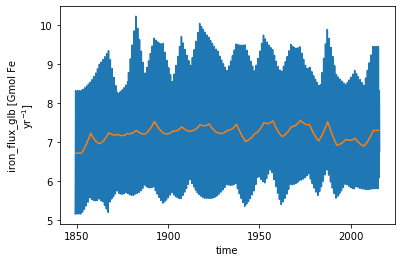

In [9]:
%%time

ds5.iron_flux_glb.plot()
esmlab.resample(ds5, freq='ann').iron_flux_glb.plot()

Compute the annual mean iron flux at year 2000

In [10]:
fe_ann_int = xr.Dataset()
for name, ds in zip(['datm_forcing', 'daily', 'monthly'], [ds5, dsd, dsm]):
    ds2000 = ds.sel(time='2000')
    fe_ann_int[name] = esmlab.weighted_sum(ds2000.iron_flux, weights=ds2000.time_bnd_diff, dim=['time'])
    fe_ann_int[name].attrs['units'] = 'Gmol Fe'

fe_ann_int = fe_ann_int.compute()
fe_ann_int

<xarray.Dataset>
Dimensions:       (ens: 3, lat: 192, lon: 288)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: ens
Data variables:
    datm_forcing  (lat, lon) float64 2.114e-08 2.115e-08 ... 2.087e-06 2.086e-06
    daily         (ens, lat, lon) float64 1.958e-08 1.958e-08 ... 1.083e-05
    monthly       (ens, lat, lon) float64 1.514e-08 1.514e-08 ... 1.018e-05

### Tune dust flux parameters to compensate for non-linearity

In [11]:
from scipy.optimize import minimize

# what parameters to tune?
opt_parms = ['dust_ratio_thres', 'fe_bioavail_frac_offset', 'dust_ratio_to_fe_bioavail_frac']

apply_log_transform = True

# define truth
#da_truth = fe_ann_int.daily.mean('ens')
da_truth = esmlab.resample(dsd, freq='mon').iron_flux.mean('ens').compute()

if apply_log_transform:
    da_truth = np.log10(da_truth)

# dataset upon which to compute and optimize flux
ds_in = ds5.sel(time='2000').compute()

TIME_AREA = xr.ones_like(da_truth) * AREA
TIME_AREA = TIME_AREA.compute()
ds_in['time'] = da_truth.time
ds_in = ds_in.reindex({'time': da_truth.time})

                    
# optimization objective function
def func(input_parms):

    # compute flux with new input parameters
    parm_kwargs = {p: input_parms[i] for i, p in enumerate(opt_parms)}
    flux = compute_iron_flux(ds_in, parms=iron_flux_parms(**parm_kwargs)).compute()
       
    if apply_log_transform:    
        flux = np.log10(flux)
    
    # compute RMS diff 
    return esmlab.weighted_rmsd(flux, da_truth, weights=TIME_AREA, dim=['time', 'lat', 'lon']) 


# get default parameters as initial guess
pdef = iron_flux_parms()
x0 = [getattr(pdef, p) for p in opt_parms]

# get initial value of objective function
init_obj = func(x0)

# perform optimization
res = minimize(func, x0, method='Nelder-Mead', tol=1e-3*init_obj)

# save results in `popt`
popt = iron_flux_parms(**{p: res.x[i] for i, p in enumerate(opt_parms)})


# print results
print('-'*60)
print('orig values')
for i, p in enumerate(opt_parms):
    print(f'{p} = {x0[i]}')

print('-'*60)    
print('new values')
for i, p in enumerate(opt_parms):
    print(f'{p} = {res.x[i]}')
print('-'*60)    

res

------------------------------------------------------------
orig values
dust_ratio_thres = 60.0
fe_bioavail_frac_offset = 0.01
dust_ratio_to_fe_bioavail_frac = 0.0058823529411764705
------------------------------------------------------------
new values
dust_ratio_thres = 69.00594084513892
fe_bioavail_frac_offset = 0.014675596610025312
dust_ratio_to_fe_bioavail_frac = 0.002729899489804088
------------------------------------------------------------


 final_simplex: (array([[6.90059408e+01, 1.46755966e-02, 2.72989949e-03],
       [6.90058897e+01, 1.46747541e-02, 2.72996965e-03],
       [6.90057567e+01, 1.46756871e-02, 2.72992010e-03],
       [6.90058750e+01, 1.46753664e-02, 2.72991631e-03]]), array([0.22428305, 0.22428305, 0.22428305, 0.22428305]))
           fun: 0.22428304960694664
       message: 'Optimization terminated successfully.'
          nfev: 144
           nit: 77
        status: 0
       success: True
             x: array([6.90059408e+01, 1.46755966e-02, 2.72989949e-03])

### Visualize new parameterization

Text(0.5, 0, 'Coarse/Fine ratio')

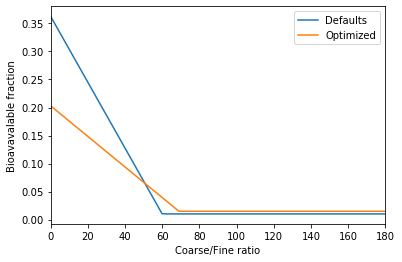

In [12]:
atm_coarse_dust_flux = np.logspace(-20, -8, 100)
atm_fine_dust_flux = np.logspace(-20, -10, 100)

bioavail = np.empty(100**2)
bioavail_opt = np.empty(100**2)
ratio = np.empty(100**2)
i = 0
for c in atm_coarse_dust_flux:
    for f in atm_fine_dust_flux:
        ratio[i] = c/f
        bioavail[i] = atm_fe_dust_bioavail_frac(c, f, pdef)
        bioavail_opt[i] = atm_fe_dust_bioavail_frac(c, f, popt)
        i += 1

I = np.argsort(ratio)
plt.plot(ratio[I], bioavail[I], '-', label='Defaults')

I = np.argsort(ratio)
plt.plot(ratio[I], bioavail_opt[I], '-', label='Optimized')

plt.xlim(0, pdef.dust_ratio_thres*3)

plt.legend()
plt.ylabel('Bioavavalable fraction')
plt.xlabel('Coarse/Fine ratio')

Compute the iron flux with the optimized parameters.

In [13]:
for ds in [ds5, dsm]:
    ds['iron_flux_opt'] = compute_iron_flux(ds, parms=popt)
    ds['iron_flux_opt_glb'] = esmlab.weighted_sum(ds.iron_flux_opt, weights=AREA, dim=['lat', 'lon']) * 1e-9 # mol --> Gmol
    ds.iron_flux_glb.attrs['units'] = 'Gmol Fe yr$^{-1}$'  

In [14]:
for name, ds in zip(['datm_forcing_opt', 'monthly_opt'], [ds5, dsm]):
    ds2000 = ds.sel(time='2000')
    fe_ann_int[name] = esmlab.weighted_sum(ds2000.iron_flux_opt, weights=ds2000.time_bnd_diff, dim=['time']).compute()
    fe_ann_int[name].attrs['units'] = 'Gmol Fe'

fe_ann_int

<xarray.Dataset>
Dimensions:           (ens: 3, lat: 192, lon: 288)
Coordinates:
  * lat               (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Dimensions without coordinates: ens
Data variables:
    datm_forcing      (lat, lon) float64 2.114e-08 2.115e-08 ... 2.086e-06
    daily             (ens, lat, lon) float64 1.958e-08 1.958e-08 ... 1.083e-05
    monthly           (ens, lat, lon) float64 1.514e-08 1.514e-08 ... 1.018e-05
    datm_forcing_opt  (lat, lon) float64 2.89e-08 2.89e-08 ... 2.647e-06
    monthly_opt       (ens, lat, lon) float64 1.914e-08 1.914e-08 ... 7.679e-06

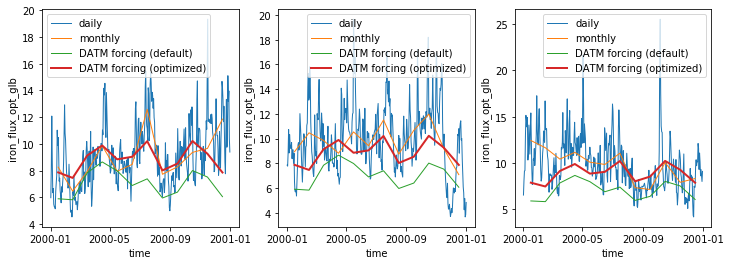

In [15]:
fig = plt.figure(figsize=(12, 4))
for i in range(0, 3):
    ax = fig.add_subplot(1, 3, i+1)
    dsd.iron_flux_glb.isel(ens=i).plot(linewidth=1, label='daily')
    dsm.iron_flux_opt_glb.isel(ens=i).plot(linewidth=1, label='monthly')
    ds5.iron_flux_glb.sel(time='2000').plot(linewidth=1, label='DATM forcing (default)')
    ds5.iron_flux_opt_glb.sel(time='2000').plot(linewidth=2, label='DATM forcing (optimized)')
    ax.legend()

Report global integrals

In [16]:
for v in fe_ann_int.data_vars:
    tot = esmlab.weighted_sum(fe_ann_int[v], weights=AREA, dim=['lat', 'lon']) * 1e-9
    if 'ens' in tot.dims:
        tot = tot.mean('ens')
    print(f'{v} = {tot.values:0.4f} Gmol Fe')

datm_forcing = 7.0418 Gmol Fe
daily = 9.6912 Gmol Fe
monthly = 7.7952 Gmol Fe
datm_forcing_opt = 8.8711 Gmol Fe
monthly_opt = 9.5315 Gmol Fe


Plot histogram

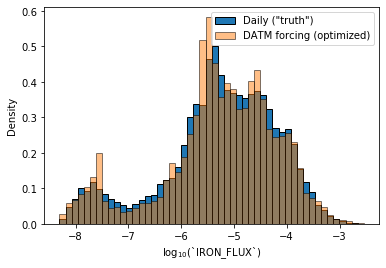

In [17]:
n, bins, ptch = plt.hist(np.log10(np.ravel(fe_ann_int.daily.data)), bins=50, alpha=1, density=True, edgecolor='k', label='Daily ("truth")')
b = plt.hist(np.log10(np.ravel(fe_ann_int.datm_forcing_opt.data)), bins=bins, alpha=0.5, density=True, edgecolor='k', label='DATM forcing (optimized)')
plt.ylabel('Density')
plt.xlabel('log$_{10}$(`IRON_FLUX`)')
plt.legend()

Text(0.5, 0, 'IRON_FLUX computed from daily data ("truth")')

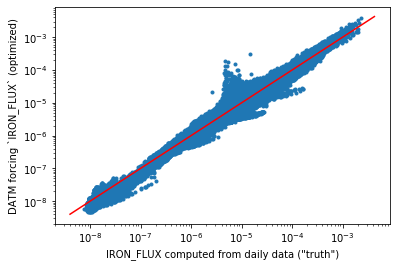

In [18]:
plt.loglog(np.ravel(fe_ann_int.daily.mean('ens').data), np.ravel(fe_ann_int.datm_forcing_opt.data), '.')
xlm = plt.gca().get_xlim()
plt.plot(xlm, xlm, 'r-')
plt.ylabel('DATM forcing `IRON_FLUX` (optimized)')
plt.xlabel('IRON_FLUX computed from daily data ("truth")')

Mean field from daily data


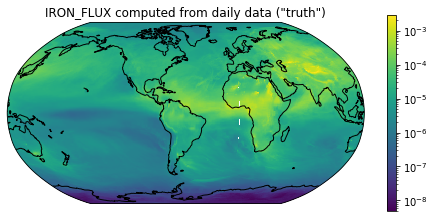

Bias


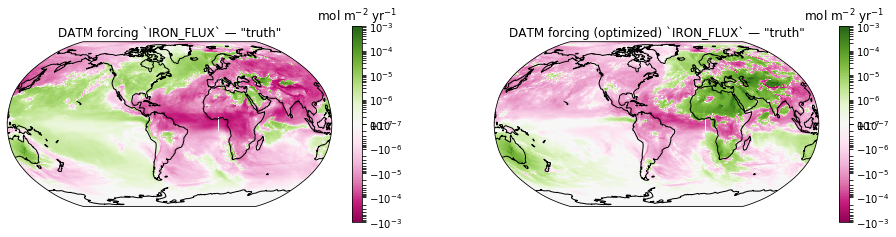

Relative bias


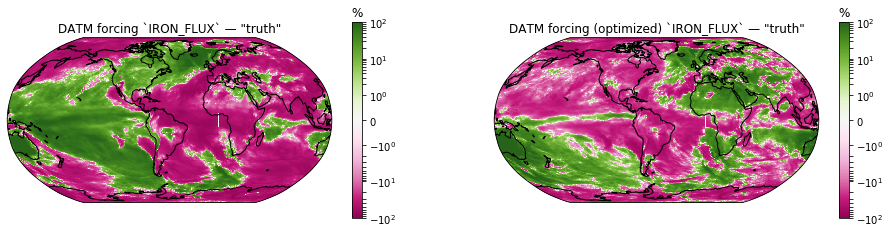

In [19]:
titles = {'daily': 'IRON_FLUX computed from daily data ("truth")', }


print('Mean field from daily data')
plt.figure(figsize=(8, 6))
for i, v in enumerate(['daily']):
    ax = plt.subplot(1, 1, i+1, projection=ccrs.Robinson(central_longitude=305.0))

    field = fe_ann_int[v]
    if 'ens' in field.dims:
        field = field.isel(ens=0)
    
    pc = ax.pcolormesh(lon, lat, field,
                       norm=colors.LogNorm(vmin=fe_ann_int.daily.min(), vmax=fe_ann_int.daily.max()),
                       transform=ccrs.PlateCarree())

    ax.set_title(titles[v])
    ax.set_global() 
    ax.coastlines()
    plt.colorbar(pc, shrink=0.6)
plt.show()

print('Bias')
titles = {'datm_forcing': 'DATM forcing `IRON_FLUX` — "truth"', 
          'datm_forcing_opt': 'DATM forcing (optimized) `IRON_FLUX` — "truth"', 
         }    
    
field_ref = fe_ann_int.daily.mean('ens')
plt.figure(figsize=(16, 6))
for i, v in enumerate(['datm_forcing', 'datm_forcing_opt']):
    ax = plt.subplot(1, 2, i+1, projection=ccrs.Robinson(central_longitude=305.0))

    field = fe_ann_int[v] - field_ref
    
    pc = ax.pcolormesh(lon, lat, field,
                       norm=colors.SymLogNorm(linthresh=1e-7, linscale=1e-7, vmin=-1e-3, vmax=1.e-3),
                       cmap='PiYG',
                       transform=ccrs.PlateCarree())

    ax.set_title(titles[v])
    ax.set_global() 
    ax.coastlines()
    cb = plt.colorbar(pc, shrink=0.6)
    cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$')
plt.show()

print('Relative bias')    
plt.figure(figsize=(16, 6))
for i, v in enumerate(['datm_forcing', 'datm_forcing_opt']):
    ax = plt.subplot(1, 2, i+1, projection=ccrs.Robinson(central_longitude=305.0))

    field = 100.*(fe_ann_int[v] - field_ref) / field_ref
    
    pc = ax.pcolormesh(lon, lat, field,
                       norm=colors.SymLogNorm(linthresh=1, linscale=1., vmin=-100, vmax=100),
                       cmap='PiYG',
                       transform=ccrs.PlateCarree())

    ax.set_title(titles[v])
    ax.set_global() 
    ax.coastlines()
    cb = plt.colorbar(pc, shrink=0.6)    
    cb.ax.set_title('%')
plt.show()

In [20]:
# Data isn't available in scratch
if False: 
    file = '/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/month_1/g.e21.G1850ECOIAF.T62_g17.003.pop.h.IRON_FLUX.000101-006212.nc'
    ds3 = xr.open_dataset(file, decode_times=False)
    ds3 = ds3.isel(time=slice(0, 24))

    file = sorted(glob('/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004/ocn/hist/g.e21.G1850ECOIAF.T62_g17.004.pop.h.????-??.nc'))
    ds4 = xr.open_mfdataset(file, decode_times=False, combine='by_coords')
    ds4 = ds4.drop([v for v in ds4.data_vars if v not in ['time', 'time_bound', 'IRON_FLUX', 'TAREA']])

    ds_list = []
    for i in range(1, 7):
        case = f'b.e21.BHIST.f09_g17.CMIP6-historical.{i:03d}'
        droot = f'/glade/collections/cdg/timeseries-cmip6/{case}/ocn/proc/tseries/month_1'
        file = f'{droot}/{case}.pop.h.IRON_FLUX.185001-201412.nc'
        if not os.path.exists(file):
            print(f'missing {file}')
            continue
        dsi = xr.open_dataset(file, decode_times=False)
        dsi = dsi.isel(time=slice(1800, 1812))
        ds_list.append(dsi)

    dsC = xr.concat(ds_list, dim='ens', data_vars=['IRON_FLUX'])

    ds3['IRON_FLUX_GLB'] = esmlab.weighted_sum(ds3.IRON_FLUX, weights=ds3.TAREA, dim=['nlat', 'nlon'])* (1.0e-16)*(365.0*86400.0)
    ds4['IRON_FLUX_GLB'] = esmlab.weighted_sum(ds4.IRON_FLUX, weights=ds4.TAREA, dim=['nlat', 'nlon'])* (1.0e-16)*(365.0*86400.0)
    dsC['IRON_FLUX_GLB'] = esmlab.weighted_sum(dsC.IRON_FLUX, weights=dsC.TAREA, dim=['nlat', 'nlon'])* (1.0e-16)*(365.0*86400.0)

    ds3['time'] = ds3.time - ds3.time[0]
    ds4['time'] = ds4.time - ds4.time[0]
    dsC['time'] = dsC.time - dsC.time[0]

In [21]:
if False:
    ds3.IRON_FLUX_GLB.isel(time=slice(0, 12)).plot(label='Original hindcast')
    ds4.IRON_FLUX_GLB.isel(time=slice(0, 12)).plot(label='Optimized hindcast', linewidth=2., marker='.')
    for i in range(0, len(dsC.ens)):
        dsC.IRON_FLUX_GLB.isel(ens=i).plot(linewidth=0.5, alpha=0.75)

    plt.legend()